# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План по проекту:**

1) Загрузим и изучим данные. Проверим дубликаты, пропуски.

2) Обучим модели.

3) Проанализруем модели.

4) Напишем вывод.

## Подготовка данных

In [1]:
#Подгрузим необходимые библиотеки
!pip install lightgbm
!pip install xgboost
!pip install catboost

import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor, cv
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
import time
import warnings

In [2]:
#Загрузим данные и изучим данные

data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
display(data)

data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
#Проверим наличие пропусков

print(data.isnull().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [4]:
# Проверим и удалим дубликаты

print('Количество дубликатов:', data.duplicated().sum())
data.drop_duplicates(inplace = True)
print('Количество дубликатов после удаления:', data.duplicated().sum())

Количество дубликатов: 4
Количество дубликатов после удаления: 0


In [5]:
# Приведем колонку с датой к правильному типу

data['DateCrawled'] = pd.to_datetime(data['DateCrawled'],format= '%Y-%m-%d %H:%M:%S') 
data['DateCreated'] = pd.to_datetime(data['DateCreated'],format= '%Y-%m-%d %H:%M:%S') 
data['LastSeen'] = pd.to_datetime(data['LastSeen'],format= '%Y-%m-%d %H:%M:%S') 

Из представленных нам данных в последующей работе нам необходимы не все столбцы с данными, а именно не несут полезной информации:

DateCrawled

PostalCode

LastSeen

NumberOfPictures

Удалим их из наших данных

In [6]:
data = data.drop(['DateCrawled', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

In [7]:
# Посмотрим более подробно на некоторые столбцы

# Столбец целевой признак "Price"

data['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

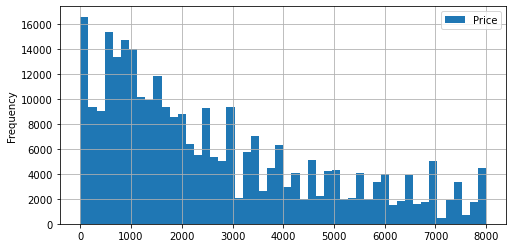

In [8]:
#у нас присутствуют нулевые значения, что неприемлемо для нашей модели, рассмотрим данные

data.plot (y = 'Price', kind = 'hist', bins = 50, grid=True, figsize = (8,4), range = (0,8000))

<AxesSubplot:ylabel='Frequency'>

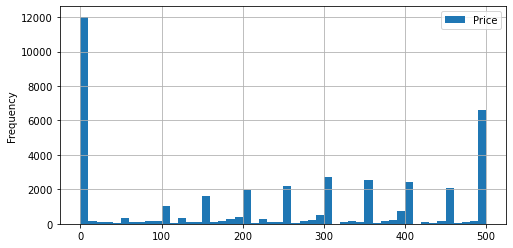

In [9]:
# теперь рассмотрим поближе значения близкие к 0

data.plot (y = 'Price', kind = 'hist', bins = 50, grid=True, figsize = (8,4), range = (0,500))

Т.к. для наших прогнозов цена является целевым признаком, то для последующих обучений моделей такой результат неприемлим, потому необходимо избавиться от объявлений без указания цены и цены менее 50 евро

In [10]:
data = data.query('Price >= 50')

Рассмотрим следующие столбцы VehicleType, Gearbox, Model, FuelType.

Т.к. во всех из них есть пропуски данных и их мы не можем восстановить по какому-нибудь похожему признаку, потому как в разные годы (и в течении одного года выпуска) автомобили одной марки могли выпускаться с разными типами кузовов, с разными коробками передач, с разными двигателями и типом топлива заменим пропущенные значения на 'unknown'

Аналогичная ситуация и со столбцом NotRepaired.

Из-за отсутствия данных, мы не можем подставить туда ни да ни нет.

In [11]:
data['VehicleType'].fillna('unknown', inplace = True)
data['Gearbox'].fillna('unknown', inplace = True)
data['Model'].fillna('unknown', inplace = True)
data['FuelType'] = data['FuelType'].replace({'petrol' : 'gasoline'})
data['FuelType'].fillna('unknown', inplace = True)
data['Repaired'].fillna('unknown', inplace = True)

C:\Users\meigh\AppData\Local\Temp\ipykernel_2844\2002405979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['VehicleType'].fillna('unknown', inplace = True)
C:\Users\meigh\AppData\Local\Temp\ipykernel_2844\2002405979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gearbox'].fillna('unknown', inplace = True)
C:\Users\meigh\AppData\Local\Temp\ipykernel_2844\2002405979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [12]:
data['Power'].describe()

count    341942.000000
mean        111.206713
std         188.254677
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Видим нулевые значения и максимальное количество авто по мощности сконцентрировано в диапазоне от 0 до 250. Рассмотрим распределение.

<AxesSubplot:ylabel='Frequency'>

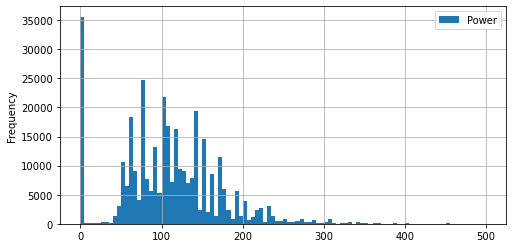

In [13]:
data.plot (y = 'Power', kind = 'hist', bins = 100, grid=True, figsize = (8,4), range = (0,500))

Мы видим, что много значений с нулевой мощностью и единичные значения с мощностью более 400-т. Заменить мы их ничем не сможем, поэтому избавимся от них.

In [14]:
data = data.query('0 < Power < 400')

In [15]:
data['RegistrationYear'].describe()

count    305667.000000
mean       2003.481501
std          29.156201
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Видим, что данные начинаются с 1000 года по 9999 год. Посмотрим поближе

<AxesSubplot:ylabel='Frequency'>

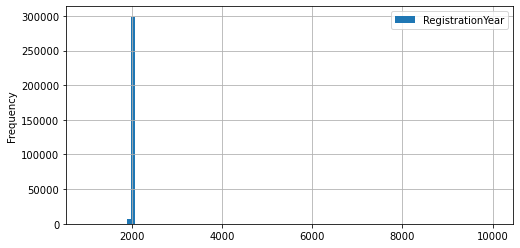

In [16]:
data.plot (y = 'RegistrationYear', kind = 'hist', bins = 100, grid=True, figsize = (8,4), range = (1000,9999))

<AxesSubplot:ylabel='Frequency'>

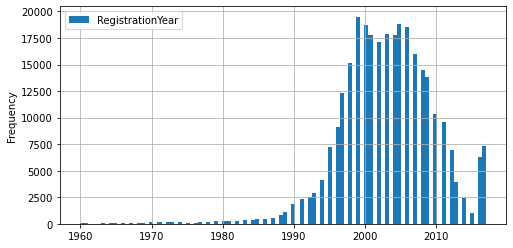

In [17]:
data.plot (y = 'RegistrationYear', kind = 'hist', bins = 100, grid=True, figsize = (8,4), range = (1960,2017))

In [18]:
data = data.query('1960 < RegistrationYear < 2017')

In [19]:
# В дальнейшем обучении моделей столбец DateCreated не несет никакой смысловой нагрузки, избавимся от него
data = data.drop(['DateCreated'], axis=1)

In [20]:
# Удалим дубликаты

data = data.drop_duplicates().reset_index(drop = True)

In [21]:
# Проверим данные

display(data.head())

display(data.info())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,10,gasoline,bmw,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272018 entries, 0 to 272017
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              272018 non-null  int64 
 1   VehicleType        272018 non-null  object
 2   RegistrationYear   272018 non-null  int64 
 3   Gearbox            272018 non-null  object
 4   Power              272018 non-null  int64 
 5   Model              272018 non-null  object
 6   Kilometer          272018 non-null  int64 
 7   RegistrationMonth  272018 non-null  int64 
 8   FuelType           272018 non-null  object
 9   Brand              272018 non-null  object
 10  Repaired           272018 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.8+ MB


None

На данном этапе мы ознакомились с данными, избавились от пустых значений, вбросов и дубликатов

## Обучение моделей

In [23]:
#Создадим функцию разбиения выборок на обучающую, валидационную и тестовую в соотношении 60:20:20

def split(df):
    features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=12345)
    return features_train, features_test, target_train, target_test

In [24]:
#Т.к проверка наших моделей будет осуществляться метрикой RMSE, создадим для нее функцию и определим переменной scorer ссылку на объект с наилучшим результатом

def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

In [25]:
#Функция обучения наших моделей, поиска наилучшей метрики RMSE и подобранных параметров

def model_look (model, parameters, features_train, target_train):
    model_grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_

In [26]:
#Преобразуем категориальные данные методом прямого кодирования для обучения модели линейной регрессии

data_ohe = data.copy
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
0,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = split(data)

In [28]:
features_train_lr = pd.get_dummies(features_train_lr, drop_first=True)
features_test_lr = pd.get_dummies(features_test_lr, drop_first=True)

In [29]:
features_train_lr.shape

(204013, 309)

In [30]:
features_test_lr.shape

(68005, 307)

In [31]:
for column in features_train_lr.columns:
    if column not in features_test_lr.columns:
        print(column)

Model_rangerover
Model_serie_2
Model_serie_3


In [32]:
del features_train_lr['Model_rangerover']
del features_train_lr['Model_serie_2']
del features_train_lr['Model_serie_3']

In [33]:
for column in features_test_lr.columns:
    if column not in features_train_lr.columns:
        print(column)

Model_range_rover_evoque


In [34]:
del features_test_lr['Model_range_rover_evoque']

## Масштабирование численных признаков

In [35]:
# выполнили здесь масштабирование через StandardScaler

scaler = StandardScaler()
scaler.fit(features_train_lr)

features_train_lr = scaler.transform(features_train_lr)
features_test_lr = scaler.transform(features_test_lr) 


## Обучение линейной регрессии

In [36]:
#Обучим модель линейной регрессии и узнаем лучшую метрику RMSE и параметры

parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
rmse, best_parameters = model_look (LinearRegression(), parameters, features_train_lr, target_train_lr)
display('Лучшие параметры модели линейной регрессии:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 1/5] END fit_intercept=True, normalize=True;, score=-2619.569 total time=   3.6s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 2/5] END fit_intercept=True, normalize=True;, score=-2578.943 total time=   3.5s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 3/5] END fit_intercept=True, normalize=True;, score=-2592.657 total time=   3.4s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 4/5] END fit_intercept=True, normalize=True;, score=-2569.270 total time=   3.5s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 5/5] END fit_intercept=True, normalize=True;, score=-2596.372 total time=   3.5s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 1/5] END fit_intercept=True, normalize=False;, score=-2619.569 total time=   3.1s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 2/5] END fit_intercept=True, normalize=False;, score=-2578.943 total time=   3.1s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 3/5] END fit_intercept=True, normalize=False;, score=-2592.657 total time=   3.2s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 4/5] END fit_intercept=True, normalize=False;, score=-2569.270 total time=   3.1s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 5/5] END fit_intercept=True, normalize=False;, score=-2596.372 total time=   3.1s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 1/5] END fit_intercept=False, normalize=True;, score=-5506.652 total time=   3.0s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 2/5] END fit_intercept=False, normalize=True;, score=-5498.335 total time=   3.0s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 3/5] END fit_intercept=False, normalize=True;, score=-5512.212 total time=   2.9s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 4/5] END fit_intercept=False, normalize=True;, score=-5482.228 total time=   3.0s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


[CV 5/5] END fit_intercept=False, normalize=True;, score=-5492.186 total time=   2.9s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 1/5] END fit_intercept=False, normalize=False;, score=-5506.652 total time=   3.0s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 2/5] END fit_intercept=False, normalize=False;, score=-5498.335 total time=   2.9s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 3/5] END fit_intercept=False, normalize=False;, score=-5512.212 total time=   3.0s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 4/5] END fit_intercept=False, normalize=False;, score=-5482.228 total time=   3.0s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV 5/5] END fit_intercept=False, normalize=False;, score=-5492.186 total time=   2.9s


C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


'Лучшие параметры модели линейной регрессии:'

{'fit_intercept': True, 'normalize': False}

'Дали RMSE модели:'

-2591.362247356451

In [37]:
results = pd.DataFrame ({'model':['LinearRegression'], 'best_parameters_train':[best_parameters], 'RMSE_train':[rmse]})

In [38]:
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247


In [39]:
#Проверим работу модели предсказаний на моделе дерева решений. Т.к. для деревянных моделей подходит больше кодирование признаков порядковым кодированием, подготовим дланные

cat_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand', 'Model']
encoder = OrdinalEncoder()
data_ordinal = data.copy()
data_ordinal[cat_columns] = encoder.fit_transform(data_ordinal[cat_columns])
data_ordinal.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,18300,2.0,2011,1.0,190,227.0,125000,5,2.0,1.0,2.0
1,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0
2,1500,5.0,2001,1.0,75,116.0,150000,6,2.0,38.0,0.0
3,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
4,650,4.0,1995,1.0,102,11.0,150000,10,2.0,2.0,2.0


In [40]:
features_train_tree, features_test_tree, target_train_tree, target_test_tree\
    = split (data_ordinal)

In [41]:
parameters = {'max_depth': range(19,21), 'min_samples_split': range(45,47)}
rmse, best_parameters = model_look (DecisionTreeRegressor(random_state=12345),\
                                    parameters, features_train_tree, target_train_tree)
display('Лучшие параметры модели дерева решений:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END max_depth=19, min_samples_split=45;, score=-1830.877 total time=   0.7s
[CV 2/5] END max_depth=19, min_samples_split=45;, score=-1826.293 total time=   0.7s
[CV 3/5] END max_depth=19, min_samples_split=45;, score=-1835.134 total time=   0.6s
[CV 4/5] END max_depth=19, min_samples_split=45;, score=-1799.830 total time=   0.6s
[CV 5/5] END max_depth=19, min_samples_split=45;, score=-1802.697 total time=   0.5s
[CV 1/5] END max_depth=19, min_samples_split=46;, score=-1831.451 total time=   0.6s
[CV 2/5] END max_depth=19, min_samples_split=46;, score=-1826.004 total time=   0.5s
[CV 3/5] END max_depth=19, min_samples_split=46;, score=-1833.503 total time=   0.6s
[CV 4/5] END max_depth=19, min_samples_split=46;, score=-1802.056 total time=   0.6s
[CV 5/5] END max_depth=19, min_samples_split=46;, score=-1802.507 total time=   0.5s
[CV 1/5] END max_depth=20, min_samples_split=45;, score=-1833.134 total time=   0.6s
[CV 2

'Лучшие параметры модели дерева решений:'

{'max_depth': 19, 'min_samples_split': 45}

'Дали RMSE модели:'

-1818.96606439004

In [42]:
results = results.append({'model':'DecisionTreeRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

C:\Users\meigh\AppData\Local\Temp\ipykernel_2844\4191634741.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model':'DecisionTreeRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)


,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064


In [43]:
#Проверим работу модели предсказаний на моделе случайного леса

parameters = {'n_estimators': range(143, 146, 1), 'max_depth': range(17,20, 1)}
rmse, best_parameters = model_look (RandomForestRegressor(random_state=12345), \
                                    parameters, features_train_tree, target_train_tree)
display('Лучшие параметры модели случайного леса:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_depth=17, n_estimators=143;, score=-1651.975 total time= 1.1min
[CV 2/5] END max_depth=17, n_estimators=143;, score=-1641.628 total time=  57.2s
[CV 3/5] END max_depth=17, n_estimators=143;, score=-1634.740 total time=  60.0s
[CV 4/5] END max_depth=17, n_estimators=143;, score=-1622.702 total time=  56.8s
[CV 5/5] END max_depth=17, n_estimators=143;, score=-1620.016 total time=  56.8s
[CV 1/5] END max_depth=17, n_estimators=144;, score=-1651.987 total time=  56.8s
[CV 2/5] END max_depth=17, n_estimators=144;, score=-1641.576 total time=  57.4s
[CV 3/5] END max_depth=17, n_estimators=144;, score=-1634.739 total time= 1.2min
[CV 4/5] END max_depth=17, n_estimators=144;, score=-1622.649 total time= 1.4min
[CV 5/5] END max_depth=17, n_estimators=144;, score=-1619.994 total time= 1.3min
[CV 1/5] END max_depth=17, n_estimators=145;, score=-1652.149 total time= 1.2min
[CV 2/5] END max_depth=17, n_estimators=145;, sco

'Лучшие параметры модели случайного леса:'

{'max_depth': 18, 'n_estimators': 144}

'Дали RMSE модели:'

-1632.0294017113279

In [44]:
results = results.append({'model':'RandomForestRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

C:\Users\meigh\AppData\Local\Temp\ipykernel_2844\3094942279.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model':'RandomForestRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)


,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402


In [45]:
#Проверим работу модели предсказаний на моделе CatBoostRegressor. Для этого переведем значения категориальных столбцов в тип 'cate

for columns in cat_columns:
    data[columns] = data[columns].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272018 entries, 0 to 272017
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              272018 non-null  int64   
 1   VehicleType        272018 non-null  category
 2   RegistrationYear   272018 non-null  int64   
 3   Gearbox            272018 non-null  category
 4   Power              272018 non-null  int64   
 5   Model              272018 non-null  category
 6   Kilometer          272018 non-null  int64   
 7   RegistrationMonth  272018 non-null  int64   
 8   FuelType           272018 non-null  category
 9   Brand              272018 non-null  category
 10  Repaired           272018 non-null  category
dtypes: category(6), int64(5)
memory usage: 12.2 MB


In [46]:
features_train, features_test, target_train, target_test\
    = split (data)

In [47]:
parameters = {'depth': range(7, 9, 1), 'iterations': range(1000, 1200, 100)}
rmse, best_parameters = model_look (CatBoostRegressor(cat_features = cat_columns, loss_function="RMSE", \
                                                      learning_rate = 0.5), parameters, features_train, target_train)
display('Лучшие параметры модели CatBoostRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 3173.3707569	total: 313ms	remaining: 5m 12s
1:	learn: 2499.3282952	total: 494ms	remaining: 4m 6s
2:	learn: 2205.8928837	total: 651ms	remaining: 3m 36s
3:	learn: 2043.9117930	total: 820ms	remaining: 3m 24s
4:	learn: 1958.3144676	total: 989ms	remaining: 3m 16s
5:	learn: 1901.6022045	total: 1.12s	remaining: 3m 5s
6:	learn: 1869.6636487	total: 1.26s	remaining: 2m 59s
7:	learn: 1847.0830591	total: 1.42s	remaining: 2m 55s
8:	learn: 1826.2132559	total: 1.57s	remaining: 2m 53s
9:	learn: 1811.8748603	total: 1.75s	remaining: 2m 53s
10:	learn: 1801.6593178	total: 1.89s	remaining: 2m 50s
11:	learn: 1791.2325386	total: 2.05s	remaining: 2m 49s
12:	learn: 1779.7369002	total: 2.22s	remaining: 2m 48s
13:	learn: 1771.4997165	total: 2.37s	remaining: 2m 47s
14:	learn: 1755.0818016	total: 2.5s	remaining: 2m 43s
15:	learn: 1745.7259810	total: 2.65s	remaining: 2m 42s
16:	learn: 1738.1320462	total: 2.77s	remaining: 2m 40s
17:	learn: 1731.99

'Лучшие параметры модели CatBoostRegressor:'

{'depth': 7, 'iterations': 1000}

'Дали RMSE модели:'

-1580.6954819236585

In [48]:
results = results.append({'model':'CatBoostRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

C:\Users\meigh\AppData\Local\Temp\ipykernel_2844\2283465853.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model':'CatBoostRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)


,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482


In [49]:
#Проверим работу модели предсказаний на моделе LGBMRegressor.

parameters = {'n_estimators':[1191, 1192]}
rmse, best_parameters = model_look (LGBMRegressor(random_state=12345), parameters, features_train, target_train)
display('Лучшие параметры модели LGBMRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .............n_estimators=1191;, score=-1539.314 total time=   5.6s
[CV 2/5] END .............n_estimators=1191;, score=-1555.076 total time=   3.7s
[CV 3/5] END .............n_estimators=1191;, score=-1536.344 total time=   3.7s
[CV 4/5] END .............n_estimators=1191;, score=-1530.877 total time=   3.7s
[CV 5/5] END .............n_estimators=1191;, score=-1528.783 total time=   3.6s
[CV 1/5] END .............n_estimators=1192;, score=-1539.337 total time=   3.7s
[CV 2/5] END .............n_estimators=1192;, score=-1555.106 total time=   3.8s
[CV 3/5] END .............n_estimators=1192;, score=-1536.353 total time=   3.8s
[CV 4/5] END .............n_estimators=1192;, score=-1530.952 total time=   3.7s
[CV 5/5] END .............n_estimators=1192;, score=-1528.843 total time=   3.7s


'Лучшие параметры модели LGBMRegressor:'

{'n_estimators': 1191}

'Дали RMSE модели:'

-1538.0788462015475

In [50]:
results = results.append({'model':'LGBMRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

C:\Users\meigh\AppData\Local\Temp\ipykernel_2844\233089953.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'model':'LGBMRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)


,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846


In [51]:
#На данном этапе мы выяснили какую метрику получают модели предсказаний и их лучшие параментры. Необходимо все это проверить на тестовой выборке

## Анализ моделей

In [52]:
#Создадим функцию для обучения, хронометража обучения и предсказания моделей

def ml_result(model, features_train, target_train, features_test, target_test):
        
    fit_up = time.time()
    model.fit(features_train, target_train)
    fit_down = time.time()
    
    fit_time = fit_down - fit_up
    
    predict_up = time.time()
    predictions = model.predict(features_test)
    predict_down = time.time()
    
    predict_time = predict_down - predict_up
    
    rmse = mean_squared_error(target_test, predictions)**0.5
      
    return fit_time, predict_time, rmse

In [53]:
#Проверим модель линейной регрессии

fit_time, predict_time, rmse = ml_result(LinearRegression(fit_intercept=True, normalize=False), features_train_lr, \
                                         target_train_lr, features_test_lr, target_test_lr)
results.loc[0, 'fit_time'] = fit_time
results.loc[0, 'predict_time'] = predict_time
results.loc[0, 'rmse_test'] = rmse
results

C:\Users\meigh\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247,3.625948,0.171018,2570.01432
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,NaN,NaN,NaN
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,NaN,NaN,NaN
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,NaN,NaN,NaN


In [54]:
#Проверим модель дерева решений

fit_time, predict_time, rmse = ml_result(DecisionTreeRegressor(random_state=12345, max_depth=19, min_samples_split=45), \
                                         features_train_tree, target_train_tree, features_test_tree, target_test_tree)
results.loc[1, 'fit_time'] = fit_time
results.loc[1, 'predict_time'] = predict_time
results.loc[1, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247,3.625948,0.171018,2570.014320
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.754054,0.017002,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,NaN,NaN,NaN
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,NaN,NaN,NaN


In [55]:
#Проверим модель случайного дерева

fit_time, predict_time, rmse = ml_result(RandomForestRegressor(random_state=12345, max_depth=18, n_estimators=144), \
                                         features_train_tree, target_train_tree, features_test_tree, target_test_tree)
results.loc[2, 'fit_time'] = fit_time
results.loc[2, 'predict_time'] = predict_time
results.loc[2, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247,3.625948,0.171018,2570.014320
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.754054,0.017002,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,75.635490,2.210164,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,NaN,NaN,NaN


In [56]:
#Проверим модель CatBoostRegressor

fit_time, predict_time, rmse = ml_result(CatBoostRegressor(cat_features=cat_columns, loss_function="RMSE", \
                                                           learning_rate = 0.5, depth=7, iterations=1000), \
                                         features_train, target_train, features_test, target_test)
results.loc[3, 'fit_time'] = fit_time
results.loc[3, 'predict_time'] = predict_time
results.loc[3, 'rmse_test'] = rmse
results

0:	learn: 3196.5809546	total: 190ms	remaining: 3m 9s
1:	learn: 2537.4509001	total: 391ms	remaining: 3m 14s
2:	learn: 2204.5122682	total: 587ms	remaining: 3m 15s
3:	learn: 2053.8749254	total: 773ms	remaining: 3m 12s
4:	learn: 1973.3740721	total: 938ms	remaining: 3m 6s
5:	learn: 1931.3642871	total: 1.11s	remaining: 3m 3s
6:	learn: 1900.5600310	total: 1.33s	remaining: 3m 9s
7:	learn: 1866.6729251	total: 1.48s	remaining: 3m 3s
8:	learn: 1850.7347759	total: 1.66s	remaining: 3m 3s
9:	learn: 1827.9880080	total: 1.84s	remaining: 3m 2s
10:	learn: 1815.3702541	total: 2.03s	remaining: 3m 2s
11:	learn: 1799.5965553	total: 2.21s	remaining: 3m 2s
12:	learn: 1787.9055276	total: 2.41s	remaining: 3m 3s
13:	learn: 1779.0813524	total: 2.61s	remaining: 3m 3s
14:	learn: 1769.3587678	total: 2.78s	remaining: 3m 2s
15:	learn: 1761.5424677	total: 2.97s	remaining: 3m 2s
16:	learn: 1752.8230315	total: 3.17s	remaining: 3m 3s
17:	learn: 1747.8382730	total: 3.34s	remaining: 3m 2s
18:	learn: 1741.9063038	total: 3.55

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247,3.625948,0.171018,2570.014320
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.754054,0.017002,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,75.635490,2.210164,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,183.572073,0.341839,1552.117225
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,NaN,NaN,NaN


In [57]:
#Проверим модель LGBMRegressor

fit_time, predict_time, rmse = ml_result(LGBMRegressor(random_state=12345, n_estimators=1191), \
                                         features_train, target_train, features_test, target_test)
results.loc[4, 'fit_time'] = fit_time
results.loc[4, 'predict_time'] = predict_time
results.loc[4, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.362247,3.625948,0.171018,2570.014320
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.754054,0.017002,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,75.635490,2.210164,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,183.572073,0.341839,1552.117225
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,4.989404,1.002075,1507.442901


Вывод по данному этапу:

На данном этапе мы проверили наши модели с полученными ранее гиперпараметрами на тесвой выборке.

Лучшая с точки зрения качества предсказания - модель LGBMRegressor

Наименьшее время обучения - модель DecisionTreeRegressor

Наменьшее время предсказания - модель DecisionTreeRegressor

## Общий вывод

По полученным результатам я бы рекомендовал модель LGBMRegressor, как соотношение качества предсказания ко времени обучения и предсказания.

Для получения результата в принятии решений в условиях задачи мной выполнено:

Открыл и изучил данные

Подготовил данные, а именно удалил дубликаты и неинформативные признаки, привели некоторые столбы к читаемому виду

Обучил моделями линейного леса, дерева решений, случайного дерева, CatBoostRegressor и LGBMRegressor

Нашел лучшие гиперпараметры данных моделей при обучении на обучающей выборке

Проверили модели с лучшими гиперпараметрами на тестовой выборке